In [1]:
# Spectral Flow Cytometry data analaysis 
# Import necessary libraries
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
import scipy.io as sio
import leidenalg
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import glob
import matplotlib.colors as mcolors
import shutil
from matplotlib.patches import Patch
from sklearn.preprocessing import RobustScaler

In [3]:
# Read the data in from the folder:
# Specify the folder path where your CSV files are located
folder_path = '/home/mali3/Downloads/concat_1/'

# Use glob to get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Create an empty list to store the DataFrames from each CSV file
dataframes = []

# Loop through each CSV file, read it into a DataFrame, and append it to the list
for csv_file in csv_files:
    df = pd.read_csv(csv_file, sep=',')  # Assuming the separator is tab, adjust if needed
    dataframes.append(df)

# Concatenate the list of DataFrames into a single DataFrame
final_df = pd.concat(dataframes, ignore_index=True)

#Show what the dataframe looks like to make sure everything is there
print(final_df.head())

     CD49d      CXCR3      CCR5     CXCR6     CD44     CD8a      CD4  \
0  792.937  1665.5300  626.2790 -1834.850  2812.00 -516.323  2205.70   
1  397.930  1537.3400  368.8620 -7157.020  7378.43 -374.679  1779.72   
2  104.243   306.6250  -46.0774  -126.441  1011.65 -207.793  2671.33   
3  456.019   -12.0405  107.8570 -2582.800  8462.21 -921.968  2031.73   
4  240.239   585.6240 -104.4560 -1009.420  3101.46 -542.493  1778.81   

        CD27      TCRY       CD28       PD1     LAG3     KLRG1    CD62L  \
0  1710.4400  2035.350  1083.8000   514.297  2591.58  1207.060  400.137   
1  2206.1900   720.082   659.1310  1724.280  1837.96   537.041  569.333   
2  1935.1900  -115.030    90.0316  1412.890  4207.44   430.021  207.931   
3    33.5948   227.017   431.8930  -332.293  1157.02   397.400  111.878   
4   554.1200   330.100   113.0990  -112.459  2559.74   109.027  213.846   

     MHCII     MHCI  SampleID  
0  6036.85  6084.92         1  
1  5169.46  8720.78         1  
2   334.79  1609.19 

In [4]:

# Assuming final_df is your DataFrame and 'SampleID' is the column with sample IDs
# Define a function to categorize each SampleID
def categorize_sample(SampleID):
    if 1 <= SampleID <= 5:
        return "Aged"
    elif 6 <= SampleID <= 12:
        return "Young"
    else:
        return "Unknown"  # Handles any SampleID that doesn't fit the provided ranges
 
# Apply the function to each entry in the 'SampleID' column
final_df['Group'] = final_df['SampleID'].apply(categorize_sample)

#Show what the dataframe looks like to make sure everything is there
print(final_df.head())

     CD49d      CXCR3      CCR5     CXCR6     CD44     CD8a      CD4  \
0  792.937  1665.5300  626.2790 -1834.850  2812.00 -516.323  2205.70   
1  397.930  1537.3400  368.8620 -7157.020  7378.43 -374.679  1779.72   
2  104.243   306.6250  -46.0774  -126.441  1011.65 -207.793  2671.33   
3  456.019   -12.0405  107.8570 -2582.800  8462.21 -921.968  2031.73   
4  240.239   585.6240 -104.4560 -1009.420  3101.46 -542.493  1778.81   

        CD27      TCRY       CD28       PD1     LAG3     KLRG1    CD62L  \
0  1710.4400  2035.350  1083.8000   514.297  2591.58  1207.060  400.137   
1  2206.1900   720.082   659.1310  1724.280  1837.96   537.041  569.333   
2  1935.1900  -115.030    90.0316  1412.890  4207.44   430.021  207.931   
3    33.5948   227.017   431.8930  -332.293  1157.02   397.400  111.878   
4   554.1200   330.100   113.0990  -112.459  2559.74   109.027  213.846   

     MHCII     MHCI  SampleID Group  
0  6036.85  6084.92         1  Aged  
1  5169.46  8720.78         1  Aged  
2 

In [5]:
final_df

CD49d       CXCR3      CCR5     CXCR6       CD44       CD8a  \
0        792.9370  1665.53000  626.2790 -1834.850  2812.0000  -516.3230   
1        397.9300  1537.34000  368.8620 -7157.020  7378.4300  -374.6790   
2        104.2430   306.62500  -46.0774  -126.441  1011.6500  -207.7930   
3        456.0190   -12.04050  107.8570 -2582.800  8462.2100  -921.9680   
4        240.2390   585.62400 -104.4560 -1009.420  3101.4600  -542.4930   
...           ...         ...       ...       ...        ...        ...   
3776799   99.9679     9.34815   65.3745  -742.598    30.2342   -46.9169   
3776800  116.7620   100.66100  123.5010 -3384.340  -873.3690   508.7900   
3776801  154.9030    82.92610  362.0600 -4208.880 -1187.0700   734.8550   
3776802  117.5000   123.90100  188.2980 -7441.670 -2176.3900  8263.6600   
3776803   14.3153   171.22600  810.3670 -5405.860 -1143.0900   831.7010   

              CD4        CD27       TCRY        CD28        PD1     LAG3  \
0        2205.700  1710.44000  2035.3500  1083.80000   514.2970  2591.58   
1        1779.720  2206.19000   720.0820   659.13100  1724.2800  1837.96   
2        2671.330  1935.19000  -115.0300    90.03160  1412.8900  4207.44   
3        2031.730    33.59480   227.0170   431.89300  -332.2930  1157.02   
4        1778.810   554.12000   330.1000   113.09900  -112.4590  2559.74   
...           ...         ...        ...         ...        ...      ...   
3776799  1885.120  1907.25000    64.8399    -8.46781  -399.8090  1029.69   
3776800  1347.780  1513.40000   123.9060   360.58300  -260.1260  1047.88   
3776801  1975.520   245.65700  -255.7240   759.05800  -879.5540  1760.65   
3776802   102.038  4872.26000  1089.1500  1989.84000    19.8275  1037.90   
3776803  1254.030    -9.83558  -345.4970   711.84900  -343.1250  1381.55   

            KLRG1     CD62L     MHCII     MHCI  SampleID  Group  
0        1207.060   400.137  6036.850  6084.92         1   Aged  
1         537.041   569.333  5169.460  8720.78         1   Aged  
2         430.021   207.931   334.790  1609.19         1   Aged  
3         397.400   111.878  2283.040  9018.17         1   Aged  
4         109.027   213.846  1955.380  2683.82         1   Aged  
...           ...       ...       ...      ...       ...    ...  
3776799   462.146  3188.120   435.363  1691.78        11  Young  
3776800   209.600  1980.980  1942.630  2927.31        11  Young  
3776801   258.762   303.341  2829.740  5820.69        11  Young  
3776802   466.970   670.078  5026.900  4040.44        11  Young  
3776803   151.799   300.112  1922.140  4682.46        11  Young  

[3776804 rows x 18 columns]

In [6]:
# Assuming the last column is 'Sample' and is metadata and not gene expression data
# Separate expression data and metadata
expr_data = final_df.iloc[:, :-2]  # all rows, all columns except the last 2
metadata = final_df[['SampleID', 'Group']]  # all rows, only the last column

In [7]:
# Convert expression data to an AnnData object
adata = sc.AnnData(expr_data)
adata.obs = metadata

# Set the gene names
adata.var_names = expr_data.columns

/home/mali3/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
# Now you can check if the gene names are correctly set
print("Gene names in adata:", adata.var_names[:50])
print("Metadata in adata:", adata.obs[:10])

Gene names in adata: Index(['CD49d', 'CXCR3', 'CCR5', 'CXCR6', 'CD44', 'CD8a', 'CD4', 'CD27',
       'TCRY', 'CD28', 'PD1', 'LAG3', 'KLRG1', 'CD62L', 'MHCII', 'MHCI'],
      dtype='object')
Metadata in adata:    SampleID Group
0         1  Aged
1         1  Aged
2         1  Aged
3         1  Aged
4         1  Aged
5         1  Aged
6         1  Aged
7         1  Aged
8         1  Aged
9         1  Aged


In [9]:
adata

AnnData object with n_obs × n_vars = 3776804 × 16
    obs: 'SampleID', 'Group'

In [9]:
# Perform PCA to reduce dimensionality before neighbor graph
sc.tl.pca(adata, svd_solver='arpack')

/home/mali3/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


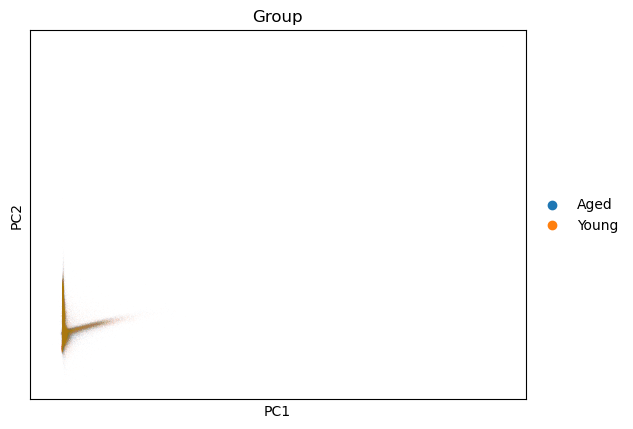

In [10]:
# Now visualize the results
sc.pl.pca(adata, color='Group')

In [11]:
## SKIPPED
# Assuming 'adata' is your AnnData object

# Define a cofactor before its use. The choice of cofactor depends on your data scale.
# Common choices for flow and mass cytometry data are in the range of 1 to 5.
#cofactor = 5

# Scale data using RobustScaler to reduce the impact of outliers
#scaler = RobustScaler()
#adata.X = scaler.fit_transform(adata.X)

# Apply Arcsinh transformation with the defined cofactor
#adata.X = np.arcsinh(adata.X / cofactor)

In [12]:
# Apply ComBat for batch correction using the 'Batch' column in adata.obs
sc.pp.combat(adata, key='Group')

In [13]:
# Apply Z-score normalization across samples for each marker
sc.pp.scale(adata)

In [14]:
# Perform PCA to reduce dimensionality before neighbor graph
sc.tl.pca(adata, svd_solver='arpack')

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


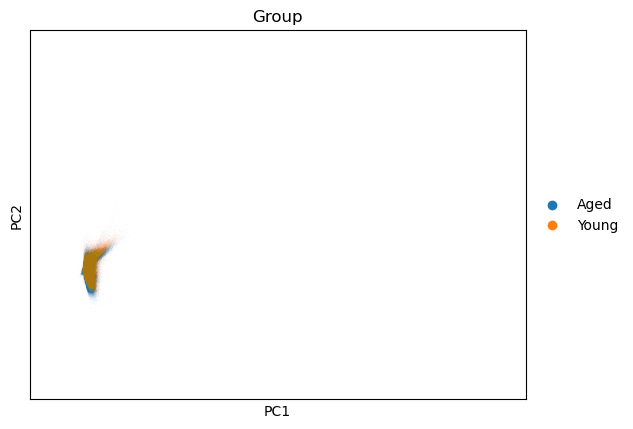

In [15]:
# Now visualize the results
sc.pl.pca(adata, color='Group')

In [16]:
adata

AnnData object with n_obs × n_vars = 3776804 × 16
    obs: 'SampleID', 'Group'
    var: 'mean', 'std'
    uns: 'pca', 'Group_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [17]:
# Run analysis steps (neighbors calculation using the PCA result, UMAP, and Leiden clustering)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')  # use the PCA representation
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

/home/mali3/.local/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_leiden.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[key_added] = pd.Categorical(


In [18]:
adata

AnnData object with n_obs × n_vars = 3776804 × 16
    obs: 'SampleID', 'Group', 'leiden'
    var: 'mean', 'std'
    uns: 'pca', 'Group_colors', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
# This saves the Anndata object with all embeddings so you can load it back into Scanpy without having to re-compute them
adata.write('/home/mali3/Downloads/concat_1/adata_Trey_methods_scaled.h5ad')

In [11]:
# If you need to read in the Anndata file, use this code 
adata = sc.read('/home/mali3/Downloads/concat_1/adata_Trey_methods_scaled.h5ad')

/home/mali3/.local/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/mali3/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


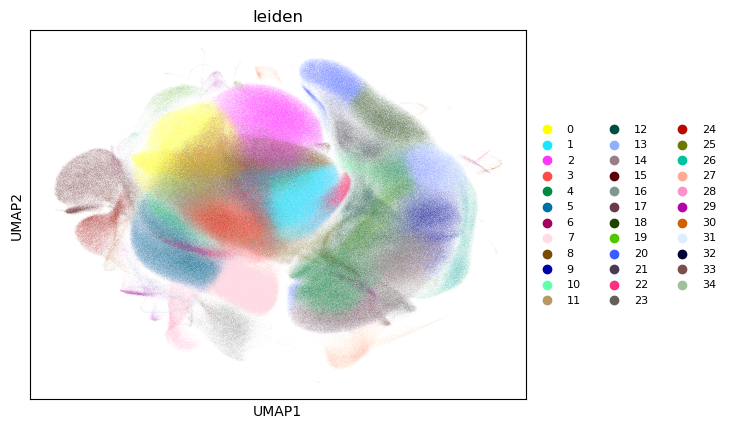

In [4]:
sc.pl.umap(adata, color='leiden', show=False, legend_fontsize=8)
#plt.savefig('/home/mali3/Downloads/concat_1/_umap_nolegends.png', dpi=300, bbox_inches='tight')
plt.show()

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


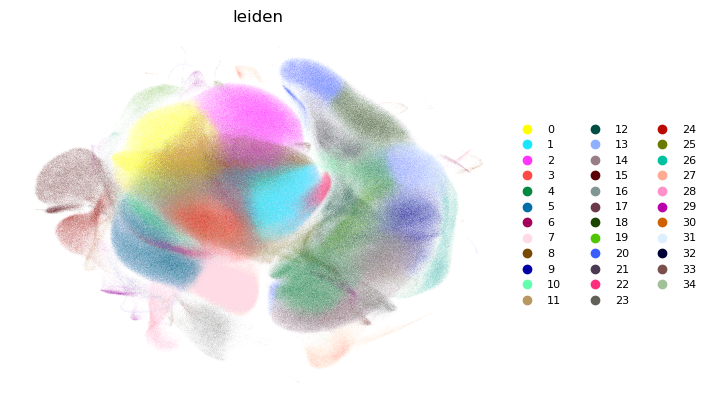

In [6]:
# If we do not set show=False, the plot may appear as a blank page in the saved file due to premature showing.

# Assuming 'adata' is your AnnData object already loaded and processed
sc.pl.umap(adata, color='leiden', legend_fontsize=8, show=False, frameon=False)  # Disable automatic showing and frame around the plot

# Save the figure before showing it
plt.savefig('/home/mali3/Downloads/concat_1/_umap_nolegends_frameon_false.png', dpi=300, bbox_inches='tight')

# Now show the plot
plt.show()


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


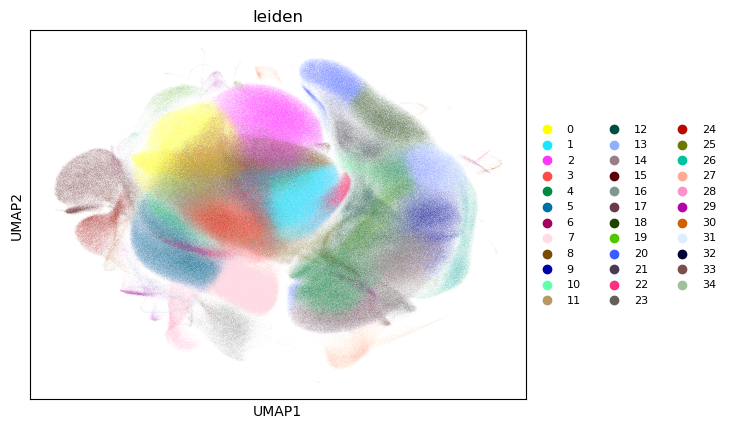

In [5]:
sc.pl.umap(adata, color='leiden',show=False, legend_fontsize=8)
#plt.savefig('/home/mali3/Downloads/concat_1/_umap_no_legends1.pdf', dpi=300, bbox_inches='tight')

# Now show the plot
plt.show()

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


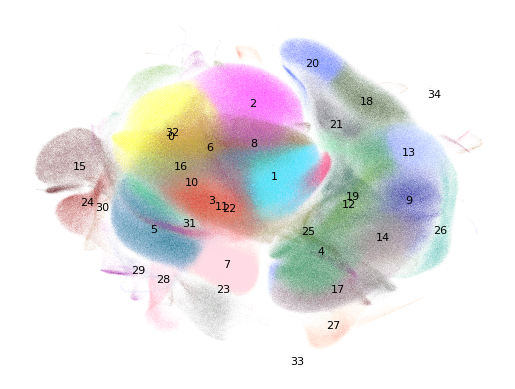

In [6]:
# Plot the UMAP and get the axis object
ax = sc.pl.umap(adata, color='leiden', legend_fontsize=8, legend_loc='on data', show=False, title='')

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove title (already done with title='' in the plotting function)
# ax.set_title('')

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Iterate through text objects and set the font weight
for text_obj in ax.texts:
    text_obj.set_weight('normal')

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/_umap_legends_on_it.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


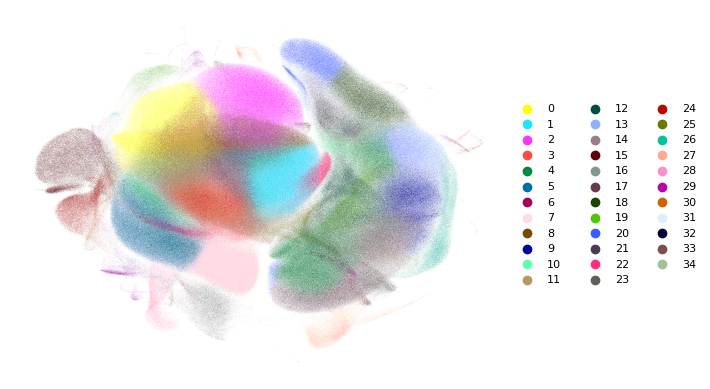

In [27]:
# Plot the UMAP and get the axis object
ax = sc.pl.umap(adata, color='leiden', legend_fontsize=8, show=False, title='')

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove title (already done with title='' in the plotting function)
# ax.set_title('')

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Iterate through text objects and set the font weight
for text_obj in ax.texts:
    text_obj.set_weight('normal')
    
# Save the figure manually
plt.savefig('/home/mali3/Downloads/concat_1/_umap1.png', dpi=300, bbox_inches='tight')

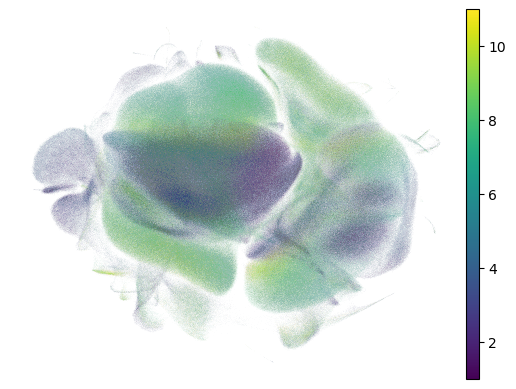

In [7]:
# Plot the UMAP and get the axis object
ax = sc.pl.umap(adata, color='SampleID', legend_fontsize=8, show=False, title='',legend_loc='right margin')

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove title (already done with title='' in the plotting function)
# ax.set_title('')

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Iterate through text objects and set the font weight
for text_obj in ax.texts:
    text_obj.set_weight('normal')

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/_umap3.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/scratch/local/ipykernel_196316/2856248153.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', 11)  # Adjust the number of colors if more clusters
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


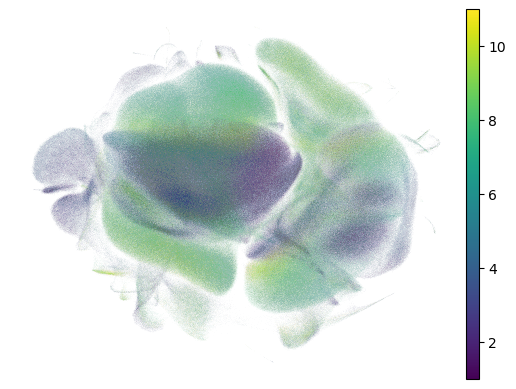

In [29]:
import scanpy as sc
import matplotlib.pyplot as plt

# Choosing a color palette with enough contrast
color_palette = plt.cm.get_cmap('tab20', 11)  # Adjust the number of colors if more clusters

# Plotting the UMAP with the custom color map
ax = sc.pl.umap(adata, color='SampleID', legend_fontsize=8, show=False, title='',
                palette=[color_palette(i) for i in range(11)])  # Assuming exactly 11 clusters

# Adjusting legend position and improving legibility
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Removing spines and labels
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

# Iterate through text objects and set the font weight for clarity
for text_obj in ax.texts:
    text_obj.set_weight('bold')  # Bold can improve readability in small figures

# Save the figure with high quality settings
plt.savefig('/home/mali3/Downloads/concat_1/_umap3.png', dpi=300, bbox_inches='tight', format='png')

# Display the plot
plt.show()


/scratch/local/ipykernel_196316/3526048231.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_palette = plt.cm.get_cmap('tab20', 20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


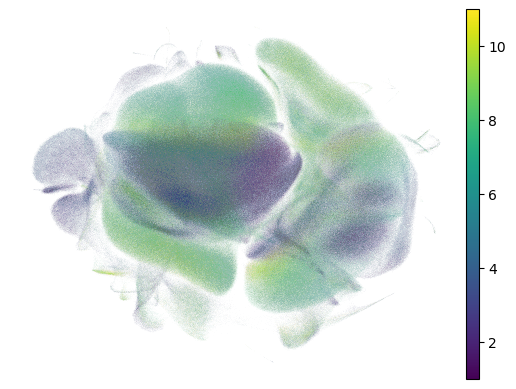

In [30]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba_array, to_hex

# Get the tab20 colormap
base_palette = plt.cm.get_cmap('tab20', 20)

# We'll take the first 11 colors and modify them slightly
original_colors = base_palette(np.linspace(0, 1, 20))

# Function to adjust lightness and saturation
def adjust_color_luminance(color, luminance_factor=1.1, saturation_factor=0.9):
    import colorsys
    r, g, b, a = to_rgba_array(color)[0]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1, max(0, l * luminance_factor))  # ensure within the range [0, 1]
    s = min(1, max(0, s * saturation_factor))  # ensure within the range [0, 1]
    new_r, new_g, new_b = colorsys.hls_to_rgb(h, l, s)
    return (new_r, new_g, new_b, a)

# Adjust colors
adjusted_colors = [adjust_color_luminance(color) for color in original_colors[:11]]

# Convert adjusted colors to hex for consistency
adjusted_colors_hex = [to_hex(color) for color in adjusted_colors]

# Plotting the UMAP with the customized tab20 color map
ax = sc.pl.umap(adata, color='SampleID', legend_fontsize=8, show=False, title='',
                palette=adjusted_colors_hex)

# Adjusting legend to be outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Cleaning up the plot
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

# Ensuring text is readable
for text_obj in ax.texts:
    text_obj.set_weight('bold')

# Save the figure
plt.savefig('/home/mali3/Downloads/concat_1/_umap_sampleID.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


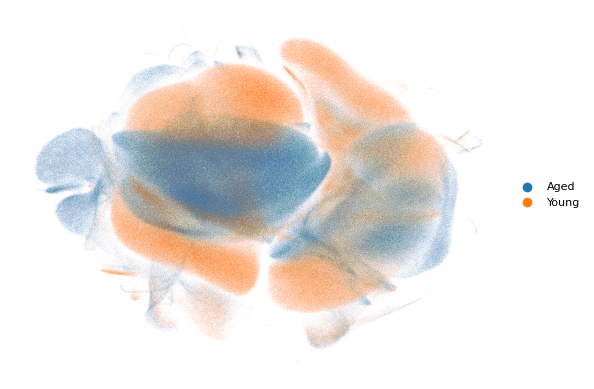

In [8]:
# Plot the UMAP and get the axis object
ax = sc.pl.umap(adata, color='Group', legend_fontsize=8, show=False, title='')

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove title (already done with title='' in the plotting function)
# ax.set_title('')

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Iterate through text objects and set the font weight
for text_obj in ax.texts:
    text_obj.set_weight('normal')

## Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/umap_Group.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

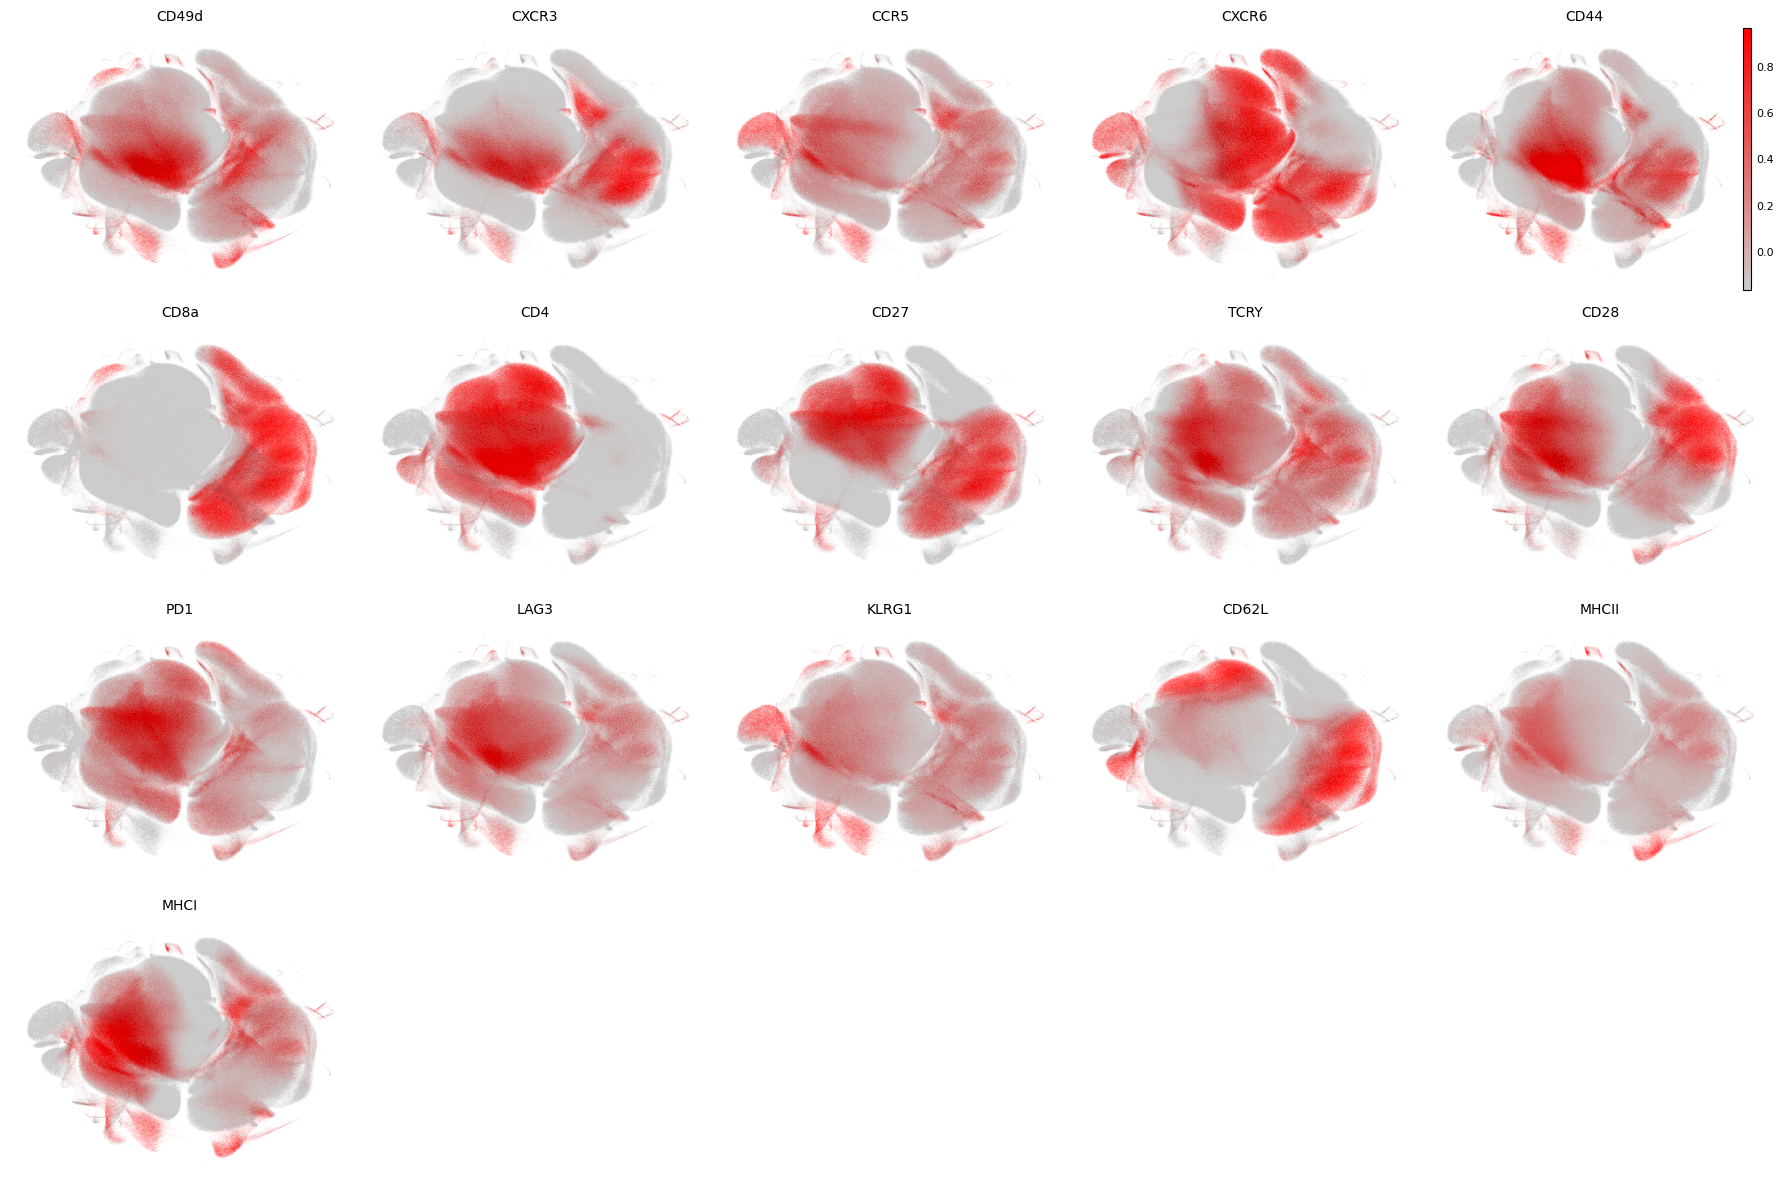

In [9]:
# Extract gene names from the AnnData object
genes_to_plot = adata.var_names.tolist()

# Define the color map
colors = [(0.8, 0.8, 0.8), (1, 0, 0)]  # light gray to red
n_bins = 100
cmap_name = 'custom_gray_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Define the genes to plot
genes_to_plot = ['CD49d', 'CXCR3', 'CCR5', 'CXCR6', 'CD44', 'CD8a', 'CD4', 'CD27',
       'TCRY', 'CD28', 'PD1', 'LAG3', 'KLRG1', 'CD62L', 'MHCII', 'MHCI']

# Calculate the percentiles for vmin and vmax across all genes
all_data = np.concatenate([adata[:, gene].X.flatten() for gene in genes_to_plot])
vmin, vmax = np.percentile(all_data, [50, 90])  # Adjust percentiles as needed

# Create a grid of subplots
n_rows = 4  # You can adjust the number of rows and columns as needed
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))

# Plot each gene's UMAP on a specific subplot
for i, gene in enumerate(genes_to_plot):
    row = i // n_cols
    col = i % n_cols
    
    ax = axes[row, col]
    sc.pl.umap(adata, color=gene, cmap=cm, vmin=vmin, vmax=vmax, show=False, title=gene, ax=ax)

    # Remove black border
    for spine in ax.spines.values():
        spine.set_edgecolor('none')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(gene, fontsize=10)

    # Handle colorbar: show only for 'Cd8a' and remove for others
    if gene == 'CD44':
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=8, which='both', length=0)  # Length=0 removes dashes
    else:
        ax.collections[0].colorbar.remove()  # Remove colorbar for other plots

# Delete the unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

# Adjust spacing between subplots and display
plt.tight_layout()

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/_umap_each_marker_gene_expression.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [10]:
unique_samples = adata.obs['SampleID'].unique()
print(unique_samples)

[ 1  2  3  4  5  6  7  8  9 10 11]


In [11]:
# Count the number of cells in each cluster
sample_counts = adata.obs['SampleID'].value_counts()

# Convert the counts to a string
counts_str = sample_counts.to_string()

# Specify the file path (change the path as needed)
file_path = os.path.expanduser('/home/mali3/Downloads/concat_1/cluster_counts_scaled.txt')

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Write the string to the file
with open(file_path, 'w') as file:
    file.write(counts_str)

print(f"Sample counts saved to {file_path}")

# Print the counts
print(sample_counts)

Sample counts saved to /home/mali3/Downloads/concat_1/cluster_counts_scaled.txt
8     604040
3     513392
2     493521
6     456437
5     366365
1     363826
4     286611
7     253600
9     171829
11    151502
10    115681
Name: SampleID, dtype: int64


/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mali3/.local/lib/python3.11/site-p

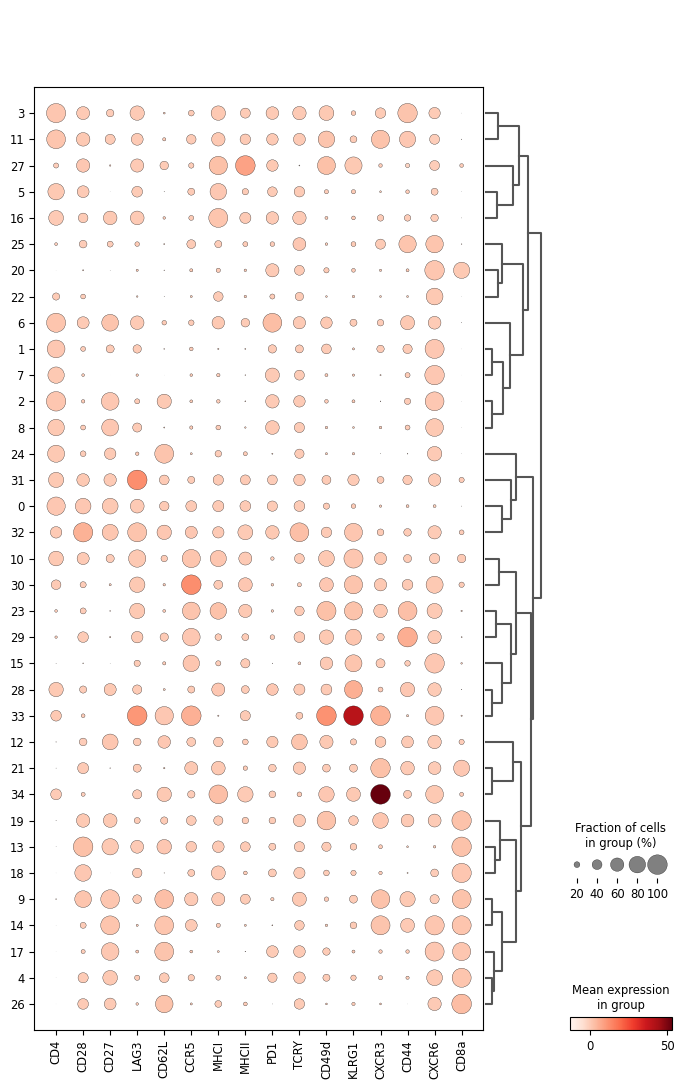

In [12]:
# Run the rank_genes_groups if not already done
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Compute the dendrogram
sc.tl.dendrogram(adata, groupby='leiden')

# Extract the top-ranked genes for the dot plot from each cluster
gene_list = [adata.uns['rank_genes_groups']['names'][i][0] for i in range(len(adata.uns['rank_genes_groups']['names']))]

# Create the dot plot for these genes, ordered by the dendrogram. Don't show it immediately.
sc.pl.dotplot(adata, var_names=gene_list, groupby='leiden', dendrogram=True, show=False)

# Now save the plot using Matplotlib's savefig, specifying the full path
#plt.savefig('/home/mali3/Downloads/concat_1/_dendogram3.pdf', dpi=300, bbox_inches='tight')

# If you want to display the plot in the notebook as well, call plt.show() after saving.
plt.show()


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


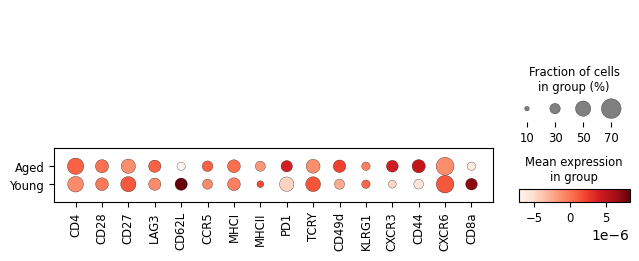

In [13]:
# Ensure dendrogram is computed for the intended groupby variable
sc.tl.dendrogram(adata, groupby='Group')

# Plot using 'Group' as groupby to align with dendrogram computation
# Use `show=False` to prevent immediate display and allow saving correctly
sc.pl.dotplot(adata, var_names=gene_list, groupby='Group', dendrogram=True, show=False)

# Save the plot using Matplotlib's savefig, specifying the full path BEFORE plt.show()
#plt.savefig('/home/mali3/Downloads/concat_1/_dotplot_group.pdf', dpi=300, bbox_inches='tight')

# Now, display the plot in the notebook or script
plt.show()

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/scratch/local/ipykernel_97810/441351945.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap


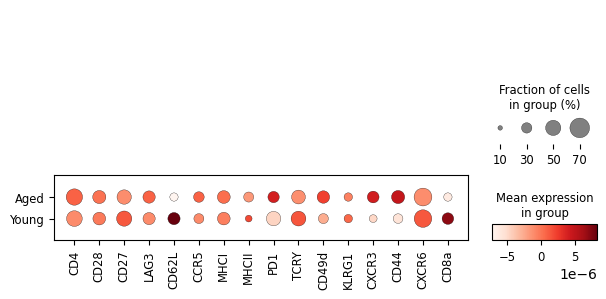

In [14]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure dendrogram is computed for the intended groupby variable
sc.tl.dendrogram(adata, groupby='Group')

# Compute the dot plot with a dendrogram
ax = sc.pl.dotplot(adata, var_names=gene_list, groupby='Group', dendrogram=True, show=False)

# Adjust the figure size and layout dynamically based on the content
plt.gcf().set_size_inches(7, 3)  # Set the figure size (width, height in inches) as needed
plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap

# Save the plot using Matplotlib's savefig
#plt.savefig('/home/mali3/Downloads/concat_1/_dotplot_group1.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

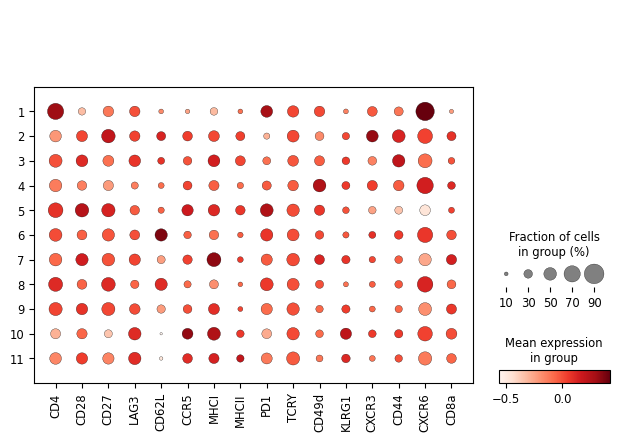

In [15]:
adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Compute dendrogram for the filtered data
sc.tl.dendrogram(adata, groupby='SampleID')

# Create dotplot
sc.pl.dotplot(adata, var_names=gene_list, groupby='SampleID', dendrogram=False, show=False)

#plt.savefig('/home/mali3/Downloads/concat_1/SampleID.pdf', dpi=300, bbox_inches='tight')

In [16]:
adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

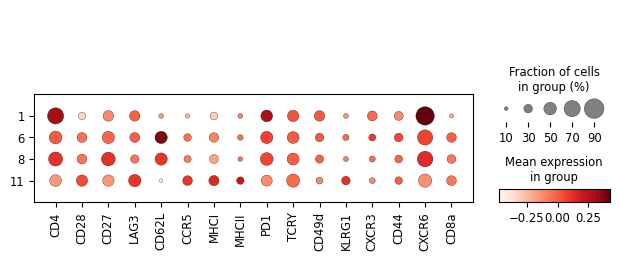

In [17]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure SampleID is set as categorical if not already
adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Filter to keep only specific SampleIDs
specific_sample_ids = [1, 6, 8, 11, 14, 16]
filtered_adata = adata[adata.obs['SampleID'].isin(specific_sample_ids)].copy()

# Compute dendrogram for the filtered data
sc.tl.dendrogram(filtered_adata, groupby='SampleID')

# Create dotplot
sc.pl.dotplot(filtered_adata, var_names=gene_list, groupby='SampleID', dendrogram=False, show=False)

# Save figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/_category.pdf', dpi=300, bbox_inches='tight')


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

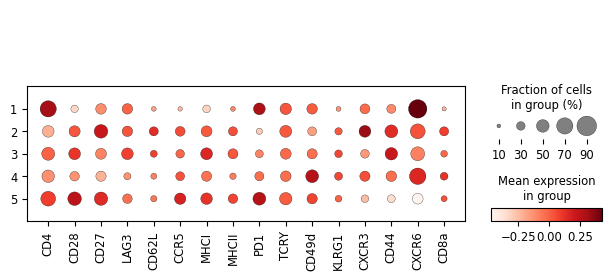

In [18]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure SampleID is set as categorical if not already
adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Filter to keep only specific SampleIDs
specific_sample_ids = [1, 2, 3, 4, 5]
filtered_adata = adata[adata.obs['SampleID'].isin(specific_sample_ids)].copy()

# Compute dendrogram for the filtered data
sc.tl.dendrogram(filtered_adata, groupby='SampleID')

# Create dotplot
sc.pl.dotplot(filtered_adata, var_names=gene_list, groupby='SampleID', dendrogram=False, show=False)

# Save figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/category_Aged.png', dpi=300, bbox_inches='tight')


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


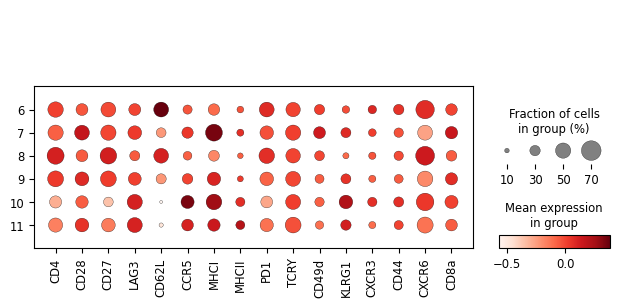

In [19]:
import scanpy as sc
import matplotlib.pyplot as plt

# Ensure SampleID is set as categorical if not already
adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Filter to keep only specific SampleIDs
specific_sample_ids = [6, 7, 8, 9, 10,11]
filtered_adata = adata[adata.obs['SampleID'].isin(specific_sample_ids)].copy()

# Compute dendrogram for the filtered data
sc.tl.dendrogram(filtered_adata, groupby='SampleID')

# Create dotplot
sc.pl.dotplot(filtered_adata, var_names=gene_list, groupby='SampleID', dendrogram=False, show=False)

# Save figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/category_young.pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [20]:
print(filtered_adata.obs['SampleID'].cat.categories)


Int64Index([6, 7, 8, 9, 10, 11], dtype='int64')


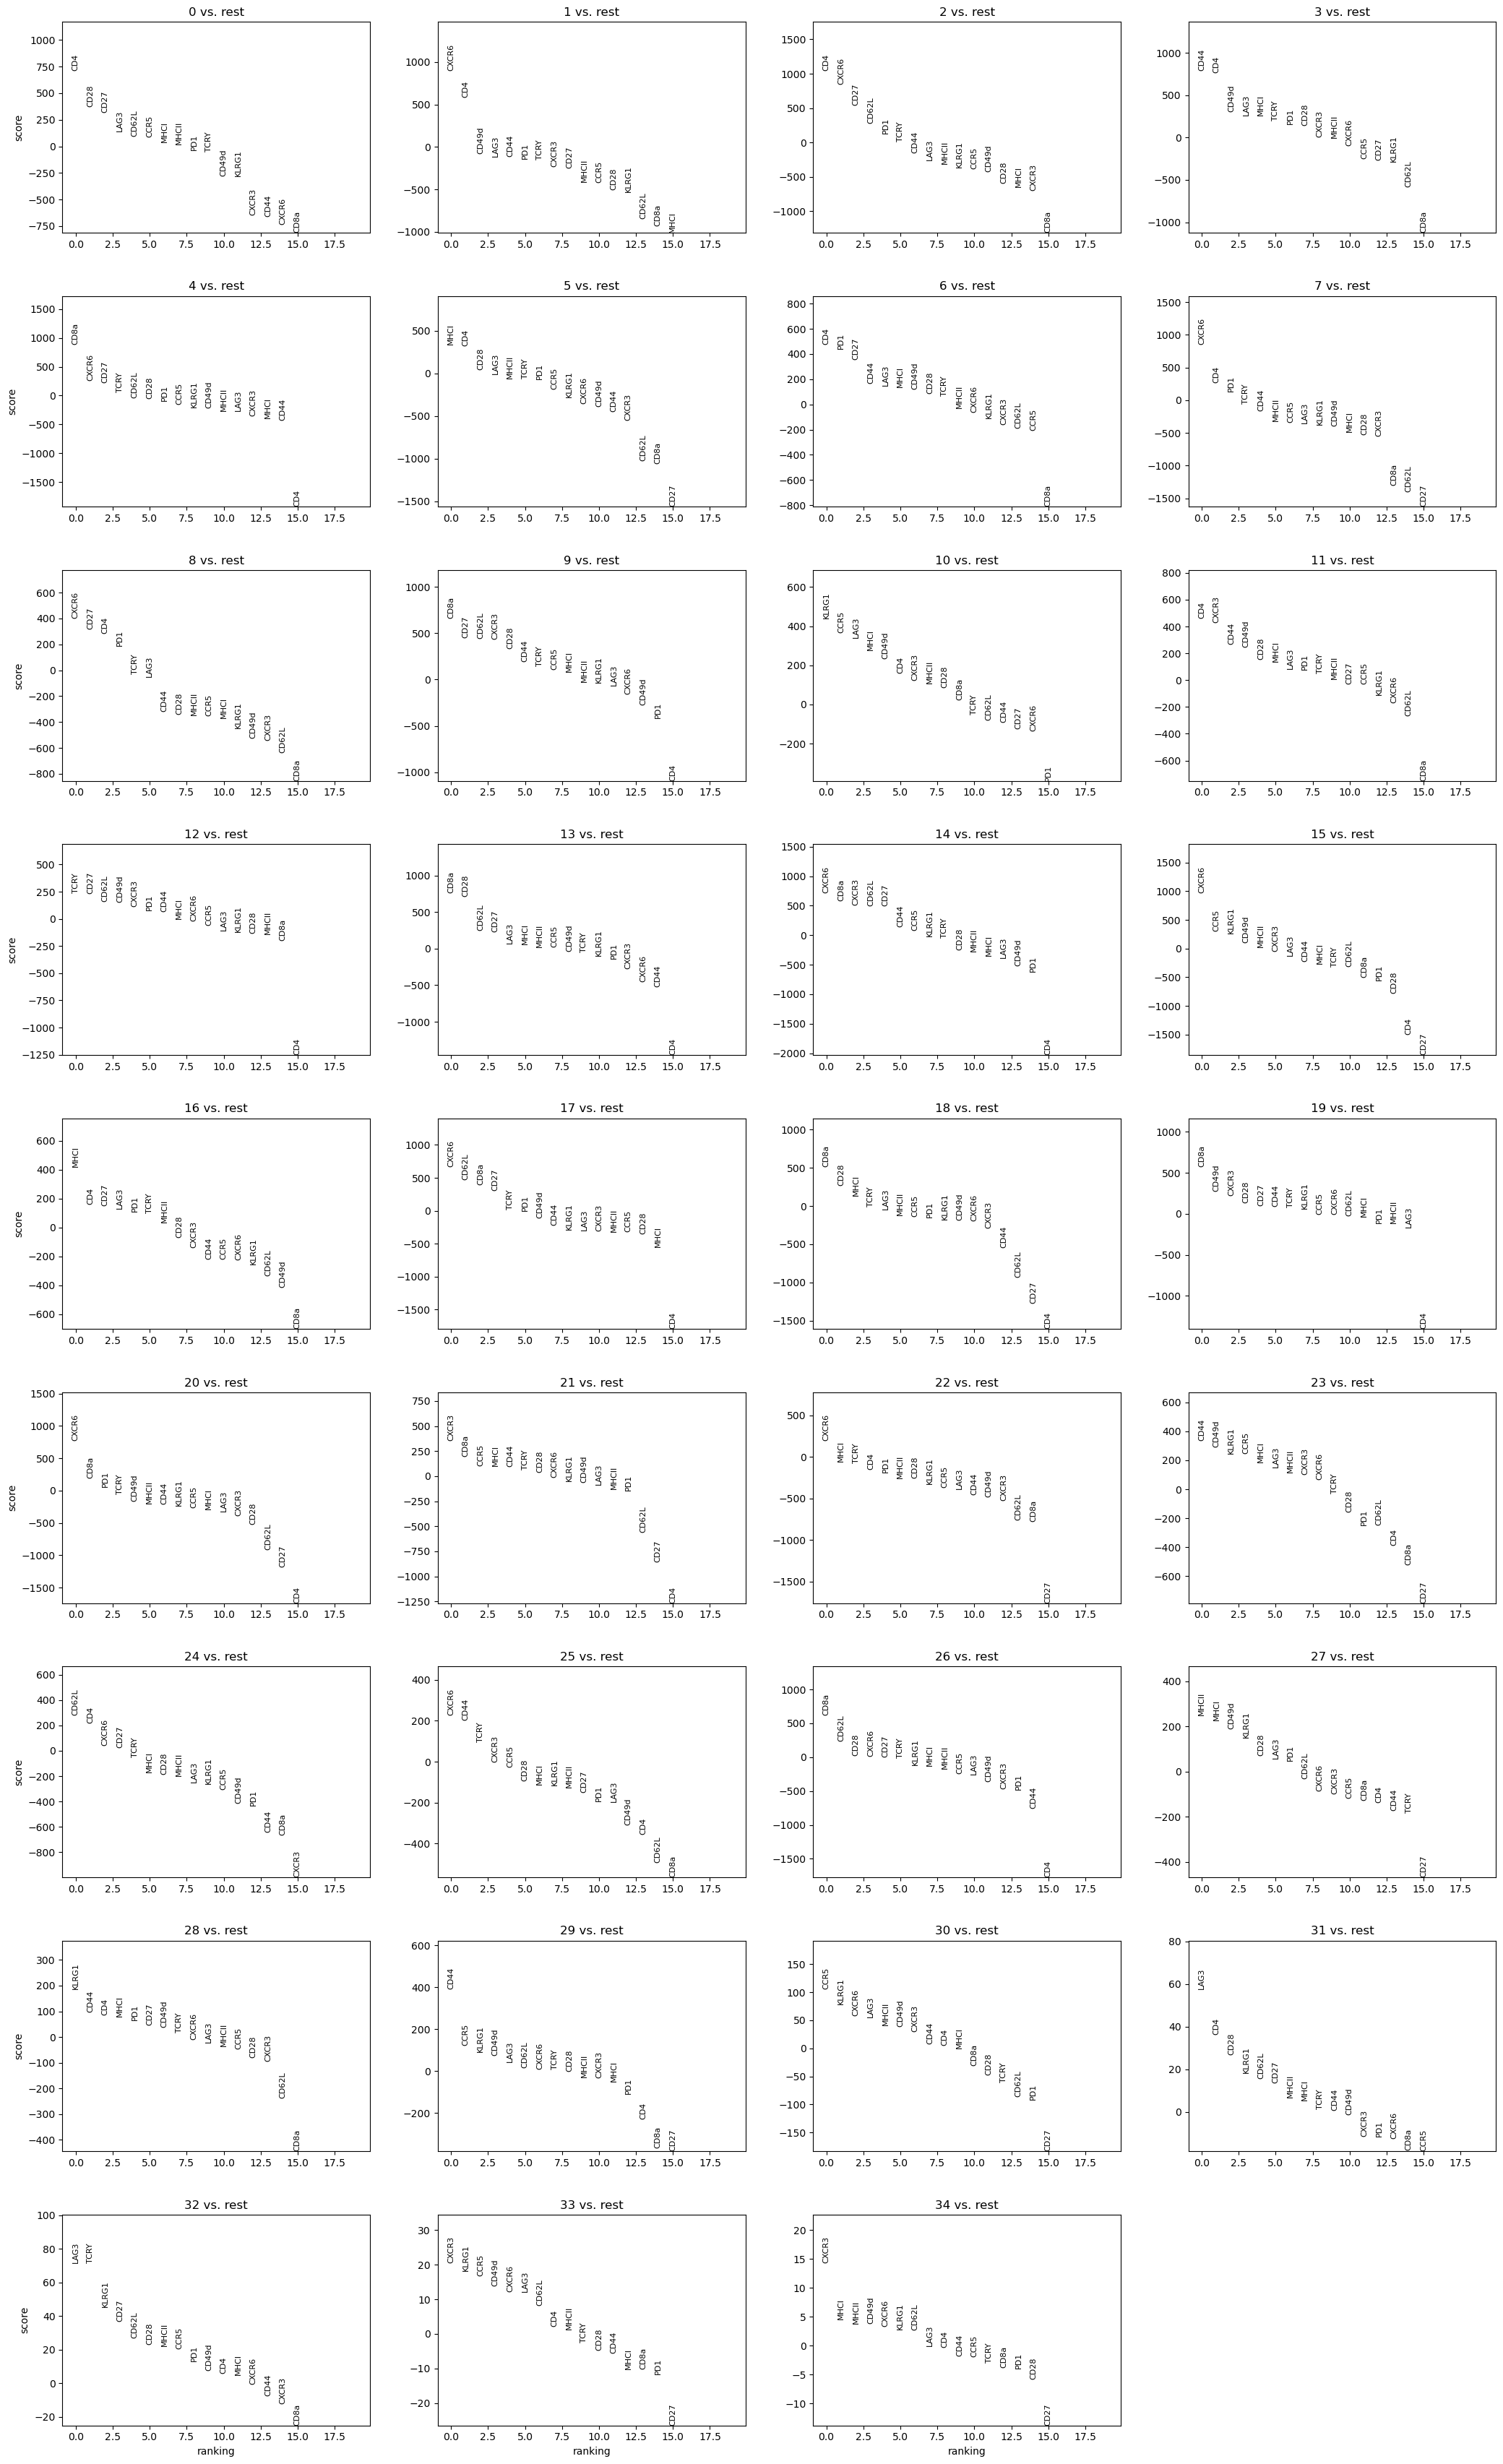

In [21]:
# Plotting the ranked genes
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

<Figure size 640x480 with 0 Axes>

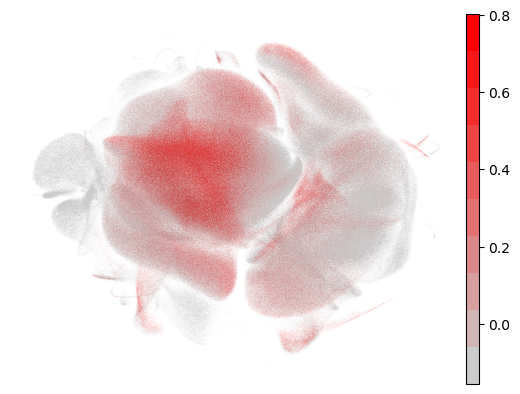

In [22]:
from matplotlib.colors import LinearSegmentedColormap

# Clear the current figure if previously plotted
plt.clf()

# Define the color map
colors = [(0.8, 0.8, 0.8), (1, 0, 0)]  # light gray to red
n_bins = 10
cmap_name = 'custom_gray_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Calculate the percentiles for vmin and vmax for PD1 expression
pd1_expression = adata[:, 'PD1'].X.flatten()  # Flatten the data if it's 2D
vmin, vmax = np.percentile(pd1_expression, [50, 90])  # Adjust percentiles as needed

# Plot UMAP with PD1 expression using the defined colormap and value range
ax = sc.pl.umap(adata, color='PD1', cmap=cm, vmin=vmin, vmax=vmax, legend_fontsize=8, show=False)

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Remove title
ax.set_title('')

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/Pd1_expression.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

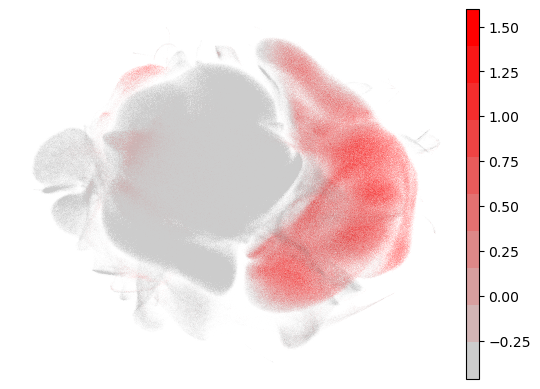

In [23]:
from matplotlib.colors import LinearSegmentedColormap

# Clear the current figure if previously plotted
plt.clf()

# Define the color map with explicit colors from gray to red
colors = [(0.8, 0.8, 0.8), (1, 0, 0)]  # light gray to red
n_bins = 10
cmap_name = 'custom_gray_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Calculate the percentiles for vmin and vmax for CD8a expression
cd8a_expression = adata[:, 'CD8a'].X.flatten()  # Flatten the data if it's 2D
vmin, vmax = np.percentile(cd8a_expression, [50, 90])  # Adjust percentiles as needed

# Plot UMAP with CD8a expression using the defined colormap and value range
ax = sc.pl.umap(adata, color='CD8a', cmap=cm, vmin=vmin, vmax=vmax, legend_fontsize=8, show=False)

# Remove the border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Remove title
ax.set_title('')

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/CD8a_expression.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home

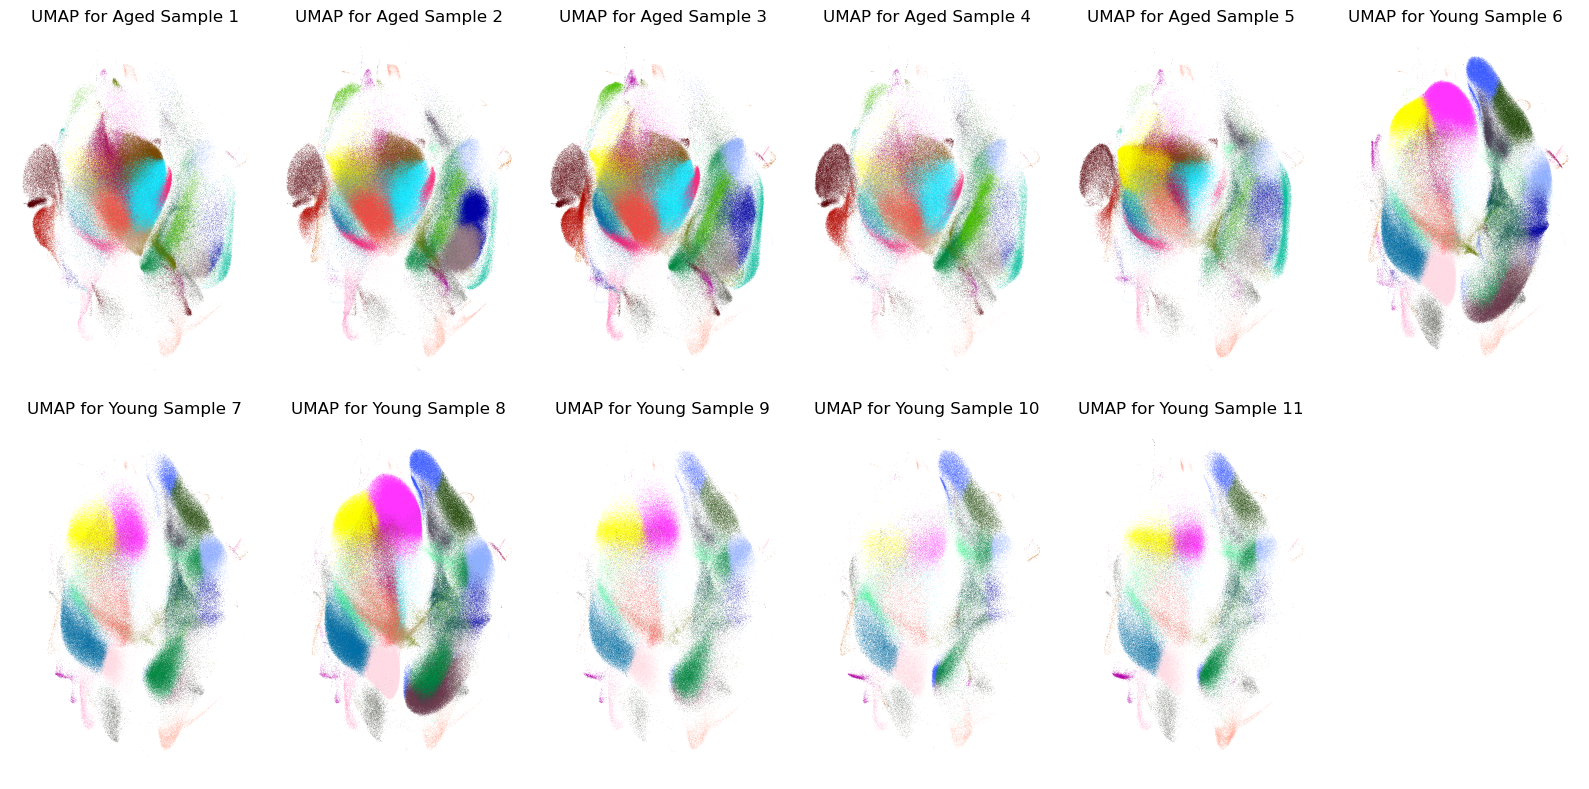

In [24]:
import matplotlib.pyplot as plt
import scanpy as sc

# Define the order of the groups for plotting based on the age category
ordered_samples = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Sample age categories, mapping sample IDs to age groups
age_categories = {
    1: 'Aged', 2: 'Aged', 3: 'Aged', 4: 'Aged', 5: 'Aged', 
    6: 'Young', 7: 'Young', 8: 'Young', 9: 'Young', 10: 'Young', 11: 'Young'
}

# Create a grid of subplots
n_rows = 2
n_cols = 6  # Adjusted to 2x6 layout for 11 samples
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharex=True, sharey=True)

# Define a fixed dot size for all UMAP plots (adjust the value as needed for your data)
dot_size = 0.2  # Adjust this value as needed

# Initialize a list to store legend handles and labels
legend_handles = []

# Iterate over each group to plot its UMAP
for i, sample_id in enumerate(ordered_samples):
    # Filter adata for the current sample
    adata_group = adata[adata.obs['SampleID'] == sample_id]

    # Determine the subplot location
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Plot UMAP with consistent dot size and axis limits
    sc.pl.umap(
        adata_group,
        color='leiden',
        legend_fontsize=6,  # Adjust font size
        size=dot_size,  # Ensure dot_size is applied
        show=False,
        ax=ax,
        title=f"UMAP for {age_categories[sample_id]} Sample {sample_id}",
        legend_loc='none',
        frameon=False  # Disable frame around the legend
    )

# After plotting all groups, determine the UMAP axis limits based on the first plot
xlim = axes.flatten()[0].get_xlim()
ylim = axes.flatten()[0].get_ylim()

# Apply the same UMAP axis limits for all plots
for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Remove the box around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Customize the subplot
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust the layout and show the plot
plt.tight_layout()

# Save the figure manually
#plt.savefig('/home/mali3/Downloads/concat_1/Umap_samples11.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [25]:
# Count the number of cells in each group
group_counts = adata.obs['Group'].value_counts()

# Convert the counts to a string
counts_str = group_counts.to_string()

# Specify the file path (change the path as needed)
file_path = os.path.expanduser('/home/mali3/Downloads/concat_1/cluster_counts_by_group_scaled.txt')

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Write the string to the file
with open(file_path, 'w') as file:
    file.write(counts_str)

print(f"Group counts saved to {file_path}")

# Print the counts
print(group_counts)

Group counts saved to /home/mali3/Downloads/concat_1/cluster_counts_by_group_scaled.txt
Aged     2023715
Young    1753089
Name: Group, dtype: int64


In [12]:
# Assuming you have already computed the Leiden clusters and stored them in 'adata'
leiden_clusters = adata.obs['leiden']  # Extract the Leiden clusters

# Add the 'leiden' column to 'final_df'
final_df['leiden'] = leiden_clusters.values

# Assuming 'final_df' has the same index as 'adata.obs'
# Add the 'Group' column from 'adata.obs' to 'final_df'
#final_df['Group'] = adata.obs['Group']

In [13]:
unique_samples = adata.obs['Group'].unique()
print(unique_samples)

['Aged', 'Young']
Categories (2, object): ['Aged', 'Young']


/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mali3/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


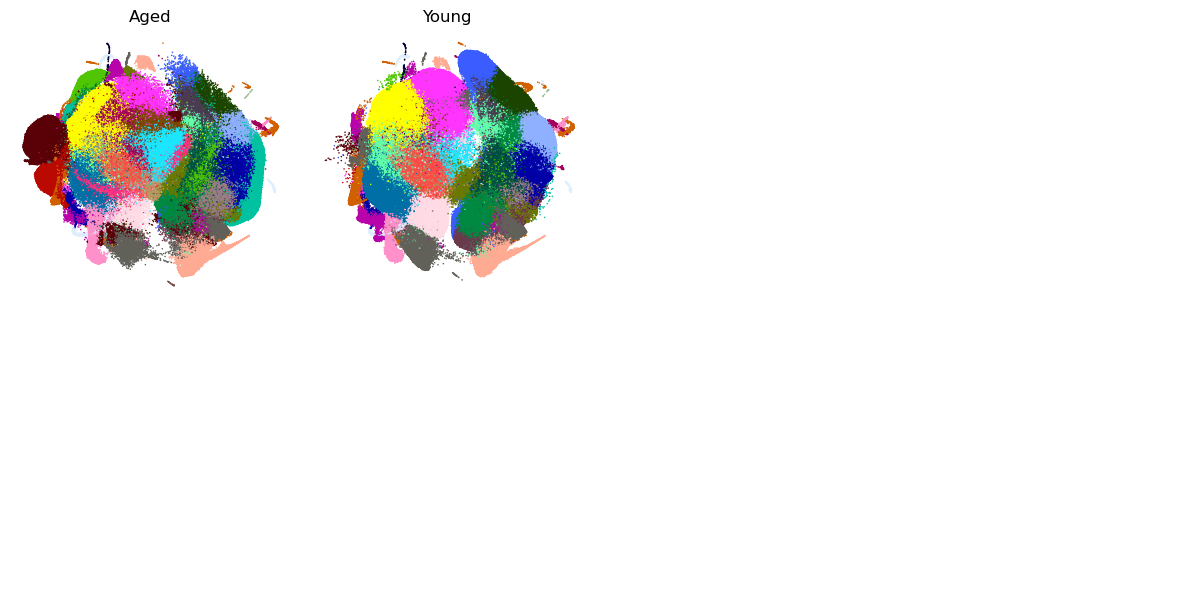

In [95]:
import os
import matplotlib.pyplot as plt
import scanpy as sc

# Define the order of the groups for plotting
ordered_groups = ['Aged', 'Young']

# Create a grid of subplots
n_rows = 2
n_cols = 4  # Adjusted to 2x2 layout for 4 groups
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6), sharex=True, sharey=True)

# Define a fixed dot size for all UMAP plots (adjust the value as needed for your data)
dot_size = 5.0  # Adjust this value as needed

# Iterate over each group to plot its UMAP
for i, group in enumerate(ordered_groups):
    # Filter adata for the current sample
    adata_group = adata[adata.obs['Group'] == group]

    # Determine the subplot location
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # Plot UMAP with consistent dot size and axis limits
    sc.pl.umap(
        adata_group,
        color='leiden',
        legend_fontsize=8,
        size=dot_size,  # Ensure dot_size is applied
        show=False,
        ax=ax,
        title=f"{group}",
        legend_loc='none'
    )

# After plotting all groups, determine the UMAP axis limits based on the first plot
xlim = axes.flatten()[0].get_xlim()
ylim = axes.flatten()[0].get_ylim()

# Apply the same UMAP axis limits for all plots
for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Remove the box around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Customize the subplot
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust the layout and save the plot
plt.tight_layout()

# Define the folder path
folder_path = '/home/mali3/Downloads/concat_1/'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the figure in the specified folder path
figure_path = os.path.join(folder_path, 'umap_group_plots2.pdf')
plt.savefig(figure_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
print(final_df.head())


     CD49d      CXCR3      CCR5     CXCR6     CD44     CD8a      CD4  \
0  792.937  1665.5300  626.2790 -1834.850  2812.00 -516.323  2205.70   
1  397.930  1537.3400  368.8620 -7157.020  7378.43 -374.679  1779.72   
2  104.243   306.6250  -46.0774  -126.441  1011.65 -207.793  2671.33   
3  456.019   -12.0405  107.8570 -2582.800  8462.21 -921.968  2031.73   
4  240.239   585.6240 -104.4560 -1009.420  3101.46 -542.493  1778.81   

        CD27      TCRY       CD28       PD1     LAG3     KLRG1    CD62L  \
0  1710.4400  2035.350  1083.8000   514.297  2591.58  1207.060  400.137   
1  2206.1900   720.082   659.1310  1724.280  1837.96   537.041  569.333   
2  1935.1900  -115.030    90.0316  1412.890  4207.44   430.021  207.931   
3    33.5948   227.017   431.8930  -332.293  1157.02   397.400  111.878   
4   554.1200   330.100   113.0990  -112.459  2559.74   109.027  213.846   

     MHCII     MHCI  SampleID Group leiden  
0  6036.85  6084.92         1  Aged     11  
1  5169.46  8720.78       

In [15]:
# Fill NaN values in the 'Group' column based on 'SampleID'
final_df.loc[final_df['SampleID'].isin([1, 2, 3, 4, 5]), 'Group'] = 'Aged'
final_df.loc[final_df['SampleID'].isin([6, 7, 8, 9, 10, 11]), 'Group'] = 'Young'

<Figure size 640x480 with 0 Axes>

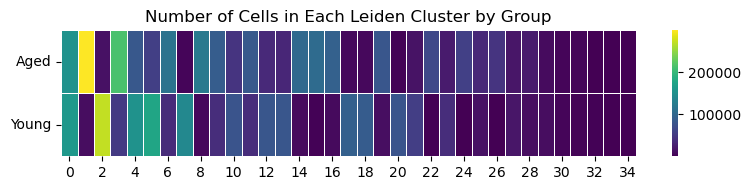

In [17]:
plt.clf()
from scipy.stats import gaussian_kde

# Make sure final_df has a 'leiden' and 'Group' column
# Example: final_df = adata.obs[['Group', 'leiden']]

# Define your custom order for 'Group'
group_order = ['Aged','Young']

# Set 'Group' in final_df as a categorical type with the specified order
final_df['Group'] = pd.Categorical(final_df['Group'], categories=group_order, ordered=True)

# Group the data by 'Group' and 'leiden' cluster, then count the number of cells in each group
heatmap_data = final_df.groupby(['Group', 'leiden']).size().unstack(fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 2))  # Adjust the figure size as needed
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='d', cbar=True, linewidths=0.5)

# Set X-axis labels using cluster labels
#num_clusters = len(cluster_labels)
#cluster_positions = np.arange(num_clusters) + 0.5  # Set the positions in the middle of each heatmap box
#plt.xticks(cluster_positions, [cluster_labels.get(i, '') for i in range(num_clusters)], rotation=90)

plt.title('Number of Cells in Each Leiden Cluster by Group')
plt.xlabel('')
plt.yticks(rotation=0)
plt.ylabel('')

# Save the heatmap as an image with additional padding
#save_path = 'hasdfeatmaasdsfdaafasdgp_4.pdf'  # Change to your desired path

#plt.savefig('/home/mali3/Downloads/concat_1/number of cell by group.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

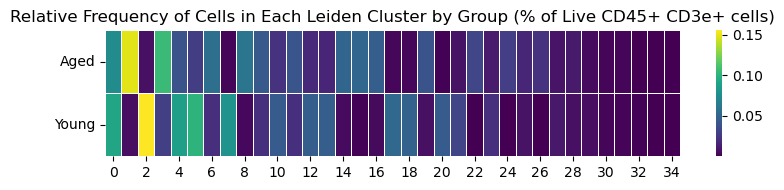

In [18]:
# Assuming you have already computed the Leiden clusters and stored them in 'adata'
leiden_clusters = adata.obs['leiden']  # Extract the Leiden clusters

# Define your custom order for 'Group'
group_order = ['Aged','Young']

# Set 'Group' in final_df as a categorical type with the specified order
final_df['Group'] = pd.Categorical(final_df['Group'], categories=group_order, ordered=True)

# Assuming you have already computed the Leiden clusters and stored them in 'final_df'
# You can group the data by 'Sample' and 'leiden' cluster, then count the number of cells in each group
heatmap_data = final_df.groupby(['Group', 'leiden']).size().unstack(fill_value=0)

# Calculate the relative frequency of cells in each cluster by dividing by the total cells in each sample
relative_freq_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 2))
sns.heatmap(relative_freq_data, cmap='viridis', annot=False, cbar=True, linewidths=0.5)

plt.title('Relative Frequency of Cells in Each Leiden Cluster by Group (% of Live CD45+ CD3e+ cells)')
plt.xlabel('')

# Set X-axis labels using cluster labels
#num_clusters = len(cluster_labels)
#cluster_positions = np.arange(num_clusters) + 0.5  # Set the positions in the middle of each heatmap box
#plt.xticks(cluster_positions, [cluster_labels[i] for i in range(num_clusters)], rotation=90)

plt.ylabel('')

# Rotate Y-axis labels
plt.yticks(rotation=0)

# Save the heatmap as an image with additional padding

#save_path = 'heatmaasdfaasdaassdfafagp_4.pdf'  # Change to your desired path
plt.savefig('/home/mali3/Downloads/concat_1/_heatmap_2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

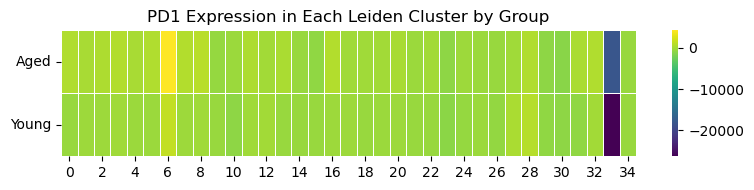

In [19]:
# Create a copy of final_df
# Its a better idea to make a copy of this dataframe before making any downstream analysis
df_copy = final_df.copy()

# Add 'custom_leiden' to df_copy from 'adata'
df_copy['leiden'] = adata.obs['leiden'].values

# Define your custom order for 'Group'
age_group_order = ['Aged','Young']

# Set 'Age_group' in the copy as a categorical type with the specified order
df_copy['Group'] = pd.Categorical(df_copy['Group'], categories=age_group_order, ordered=True)

# Group the data in the copy by 'Age_group' and 'custom_leiden', then calculate the mean KLRG1 expression
Expression_data = df_copy.groupby(['Group', 'leiden'])['PD1'].mean().unstack(fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 2))
sns.heatmap(Expression_data, cmap='viridis', annot=False, cbar=True, linewidths=0.5)

plt.title('PD1 Expression in Each Leiden Cluster by Group')
plt.xlabel('')

# Use custom_leiden cluster labels for x-axis
#cluster_labels = adata.obs['custom_leiden'].cat.categories.tolist()
#num_clusters = len(cluster_labels)
#cluster_positions = np.arange(num_clusters) + 0.5
#plt.xticks(cluster_positions, cluster_labels, rotation=90)

plt.ylabel('')
plt.yticks(rotation=0)

# Adjust layout to fit everything, and display the plot
plt.tight_layout()

# Save the plot using Matplotlib's savefig, specifying the full path
plt.savefig('/home/mali3/Downloads/concat_1/_heatmap_PD1.pdf', dpi=300, bbox_inches='tight')

plt.show()

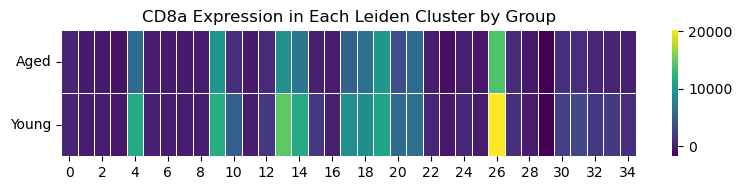

In [21]:
# Create a copy of final_df
# Its a better idea to make a copy of this dataframe before making any downstream analysis
df_copy = final_df.copy()

# Add 'leiden' cluster information to df_copy from 'adata'
df_copy['leiden'] = adata.obs['leiden'].values

# Define your custom order for 'Group', here assuming 'Group' refers to age groups
age_group_order = ['Aged', 'Young']

# Set 'Group' in the copy as a categorical type with the specified order
df_copy['Group'] = pd.Categorical(df_copy['Group'], categories=age_group_order, ordered=True)

# Group the data in the copy by 'Group' and 'leiden', then calculate the mean CD8a expression
# Note: Adjust the column name if CD8a is stored under a different name in your DataFrame
Expression_data = df_copy.groupby(['Group', 'leiden'])['CD8a'].mean().unstack(fill_value=0)

# Create a heatmap using seaborn to visualize the mean expression of CD8a
plt.figure(figsize=(8, 2))
sns.heatmap(Expression_data, cmap='viridis', annot=False, cbar=True, linewidths=0.5)  # set annot=True for annotations if needed

plt.title('CD8a Expression in Each Leiden Cluster by Group')
plt.xlabel('')  # Assuming the column names in Expression_data are Leiden clusters
plt.ylabel('')
plt.yticks(rotation=0)  # Keeps the y-axis labels horizontal

# Adjust layout to fit everything, and display the plot
plt.tight_layout()

# Save the plot using Matplotlib's savefig, specifying the full path
plt.savefig('/home/mali3/Downloads/concat_1/_heatmap_CD8a.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


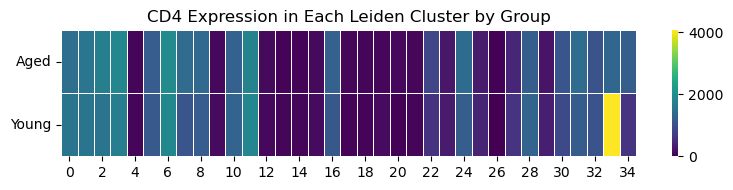

In [22]:
# Create a copy of final_df
# Its a better idea to make a copy of this dataframe before making any downstream analysis
df_copy = final_df.copy()

# Add 'leiden' cluster information to df_copy from 'adata'
df_copy['leiden'] = adata.obs['leiden'].values

# Define your custom order for 'Group', here assuming 'Group' refers to age groups
age_group_order = ['Aged', 'Young']

# Set 'Group' in the copy as a categorical type with the specified order
df_copy['Group'] = pd.Categorical(df_copy['Group'], categories=age_group_order, ordered=True)

# Group the data in the copy by 'Group' and 'leiden', then calculate the mean CD4 expression
# Adjust the column name if CD4 is stored under a different name in your DataFrame
Expression_data = df_copy.groupby(['Group', 'leiden'])['CD4'].mean().unstack(fill_value=0)

# Create a heatmap using seaborn to visualize the mean expression of CD4
plt.figure(figsize=(8, 2))
sns.heatmap(Expression_data, cmap='viridis', annot=False, cbar=True, linewidths=0.5)  # set annot=True for annotations if needed

plt.title('CD4 Expression in Each Leiden Cluster by Group')
plt.xlabel('')  # Assuming the column names in Expression_data are Leiden clusters
plt.ylabel('')
plt.yticks(rotation=0)  # Keeps the y-axis labels horizontal

# Adjust layout to fit everything, and display the plot
plt.tight_layout()

# Save the plot using Matplotlib's savefig, specifying the full path
plt.savefig('/home/mali3/Downloads/concat_1/_heatmap_CD4.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

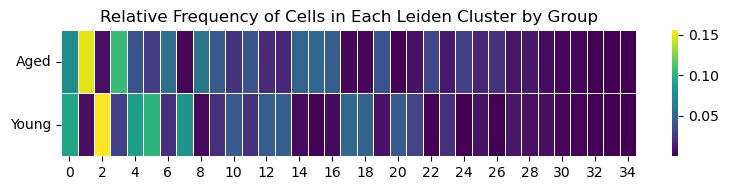

In [100]:
# Extract the Leiden clusters from the 'adata' object (Assuming this is an AnnData object commonly used in single-cell RNA-seq)
leiden_clusters = adata.obs['leiden']

# Define a custom order for groups like 'Aged' and 'Young' which might represent different conditions or age groups
group_order = ['Aged', 'Young']

# Convert the 'Group' column in 'final_df' to a categorical type with the specified order to ensure plots respect this ordering
final_df['Group'] = pd.Categorical(final_df['Group'], categories=group_order, ordered=True)

# Group data by 'Group' and 'leiden' cluster, then count the number of cells in each group to form the heatmap data
heatmap_data = final_df.groupby(['Group', 'leiden']).size().unstack(fill_value=0)

# Calculate the relative frequency of cells in each cluster by dividing by the total number of cells in each group
relative_freq_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Create a heatmap using seaborn to visualize these relative frequencies
plt.figure(figsize=(8, 2))
sns.heatmap(relative_freq_data, cmap='viridis', annot=False, cbar=True, linewidths=0.5)

# Set titles and labels
plt.title('Relative Frequency of Cells in Each Leiden Cluster by Group')
plt.xlabel('')
plt.ylabel('')

# Rotate Y-axis labels to horizontal for better readability
plt.yticks(rotation=0)

# Adjust layout to fit everything neatly
plt.tight_layout()

# Save the heatmap as an image with high resolution and tight bounding box
plt.savefig('/home/mali3/Downloads/concat_1/_heatmap_2.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [61]:
# making a copy of adata
adata_copy3 = adata.copy()
# Extract the expression data for CD8a directly from the AnnData object
cd8a_expression = pd.DataFrame(adata_copy3[:, 'CD8a'].X, columns=['CD8a'], index=adata_copy3.obs_names)

# Calculate the sum of expression for CD8a for each cluster
cd8a_sum_per_cluster = cd8a_expression.groupby(adata_copy3.obs['leiden']).sum()['CD8a']

# Sort the clusters based on the summed CD8a expression in descending order
sorted_clusters_cd8a = cd8a_sum_per_cluster.sort_values(ascending=False).index

print("Leiden clusters sorted by CD8a expression (from highest to lowest):")
print(sorted_clusters_cd8a)

Leiden clusters sorted by CD8a expression (from highest to lowest):
CategoricalIndex(['4', '13', '9', '19', '14', '26', '17', '18', '21', '20',
                  '10', '33', '34', '32', '31', '30', '27', '29', '28', '24',
                  '25', '22', '12', '15', '23', '16', '8', '11', '6', '7', '5',
                  '0', '1', '3', '2'],
                 categories=['0', '1', '2', '3', ..., '31', '32', '33', '34'], ordered=False, dtype='category', name='leiden')


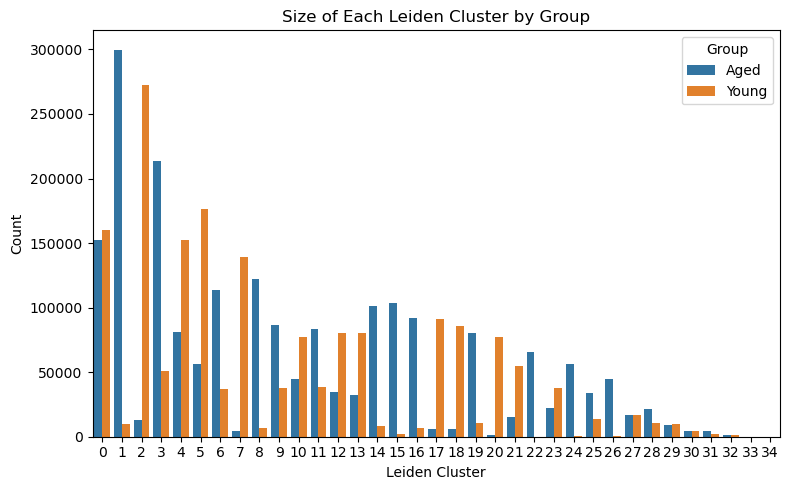

In [101]:
# Assuming you have already computed the Leiden clusters and stored them in 'final_df'
# You can group the data by 'Group' and 'leiden' cluster, then count the number of cells in each group
cluster_sizes = final_df.groupby(['Group', 'leiden']).size().reset_index(name='Count')

# Create a bar plot using seaborn
plt.figure(figsize=(8, 5))  # Adjust the size as needed
sns.barplot(data=cluster_sizes, x='leiden', y='Count', hue='Group')

# Add cluster labels to the x-axis ticks
#num_clusters = len(cluster_labels)
#cluster_positions = np.arange(num_clusters)
#plt.xticks(cluster_positions, [cluster_labels[i] for i in range(num_clusters)], rotation=90)

plt.title('Size of Each Leiden Cluster by Group')
plt.xlabel('Leiden Cluster')
plt.ylabel('Count')
plt.legend(title='Group', loc='upper right')

plt.tight_layout()
# Save the plot 
plt.savefig('/home/mali3/Downloads/concat_1/_cluster_sizes_barplot1.pdf', dpi=300, bbox_inches='tight')

plt.show()

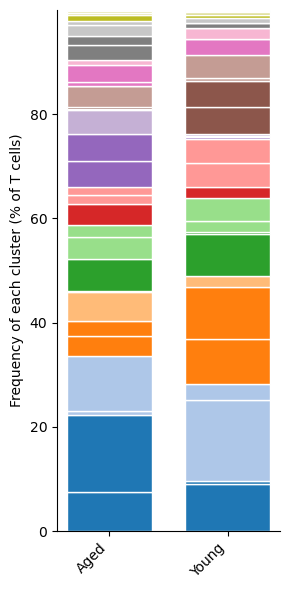

In [20]:
# Ensure 'Group' is ordered as per your custom order for plotting
adata.obs['Group'] = pd.Categorical(adata.obs['Group'], categories=group_order, ordered=True)

# Recount with the 'Group' now ordered
cluster_group_counts = adata.obs.groupby(['leiden', 'Group']).size().unstack(fill_value=0)

# Normalize the counts to percentages
relative_cell_percentages = cluster_group_counts.div(cluster_group_counts.sum(axis=0), axis=1) * 100

# Bar width
bar_width = 0.25
spacing = 0.1  # The spacing between adjacent bars

# Plot the stacked bar chart for relative cell percentages
fig, ax = plt.subplots(figsize=(3, 6)) 

# Define the starting x positions for the bars
bar_l = np.arange(len(group_order)) * (bar_width + spacing)

# Using the 'tab20' colormap for better color distinction
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_group_counts.index)))

for i, cluster in enumerate(cluster_group_counts.index):
    # Plot each cluster's percentages for each group, one on top of the other
    bottoms = relative_cell_percentages.iloc[:i].sum() if i > 0 else None
    ax.bar(bar_l, relative_cell_percentages.loc[cluster], color=colors[i], edgecolor='white', width=bar_width, label=f'Cluster {cluster}', bottom=bottoms)

# Formatting the plot
ax.set_xticks(bar_l)
ax.set_xticklabels(group_order, rotation=45, ha='right')
ax.set_ylabel('Frequency of each cluster (% of T cells)')
ax.set_xlabel('')
ax.set_title('')
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create legend
#legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}') for i, cluster in enumerate(cluster_group_counts.index)]
#ax.legend(handles=legend_elements, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

#plt.savefig('/home/mali3/Downloads/concat_1/_stacked_bar_plot.pdf', dpi=300, bbox_inches='tight')

plt.show()

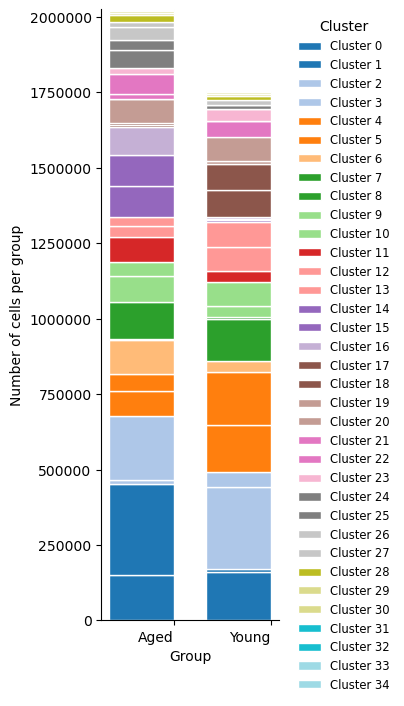

In [103]:
# Assuming 'adata' is your AnnData object and it's already loaded
# Custom order of groups for plotting
group_order = ['Aged', 'Young']
adata.obs['Group'] = pd.Categorical(adata.obs['Group'], categories=group_order, ordered=True)
cluster_group_counts = adata.obs.groupby(['leiden', 'Group']).size().unstack(fill_value=0)

# Define the bar width and the spacing between groups
bar_width = 0.4
group_spacing = 0.2  # Space between the groups

# Calculate the x position of the first bar in each group
bar_positions = np.arange(len(group_order)) * (bar_width + group_spacing)

# Create the plot with a larger figure size for better readability and space for legend
fig, ax = plt.subplots(figsize=(5, 7.5))  # Adjusted figure size for better display

# Using the 'tab20' colormap for better color distinction
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_group_counts.index)))

for i, cluster in enumerate(cluster_group_counts.index):
    # Plot each cluster's counts for each group, one on top of the other
    bottoms = cluster_group_counts.iloc[:i].sum() if i > 0 else np.zeros_like(bar_positions)
    ax.bar(bar_positions, cluster_group_counts.loc[cluster], color=colors[i], edgecolor='white', width=bar_width, label=f'Cluster {cluster}', bottom=bottoms)

# Formatting the plot
ax.ticklabel_format(style='plain', axis='y')

# Set the x-ticks to be in the center of the groups
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(group_order, rotation=0, ha='right')
ax.set_ylabel('Number of cells per group')
ax.set_xlabel('Group')

# Remove the top and right spines for cleaner aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Creating a legend and positioning it outside the plot on the right, with a smaller font size for compact fit
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize='small')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle in which to fit the plot and legend
plt.savefig('/home/mali3/Downloads/concat_1/_stacked_bar_plot_with_cluster_number.pdf', dpi=300, bbox_inches='tight')
plt.show()


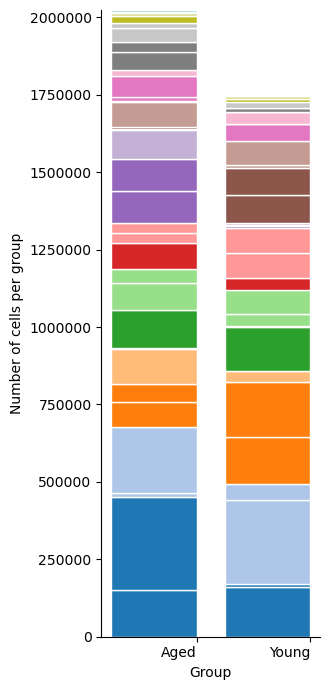

In [104]:
# Assuming 'adata' is your AnnData object and it's already loaded
# Custom order of groups for plotting
group_order = ['Aged', 'Young']
adata.obs['Group'] = pd.Categorical(adata.obs['Group'], categories=group_order, ordered=True)
cluster_group_counts = adata.obs.groupby(['leiden', 'Group']).size().unstack(fill_value=0)

# Define the bar width and the spacing between groups
bar_width = 0.3
group_spacing = 0.1  # Space between the groups

# Calculate the x position of the first bar in each group
bar_positions = np.arange(len(group_order)) * (bar_width + group_spacing)

# Create the plot with a larger figure size for better readability and space for legend
fig, ax = plt.subplots(figsize=(4, 7))  # Adjusted figure size for better display

# Using the 'tab20' colormap for better color distinction
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_group_counts.index)))

for i, cluster in enumerate(cluster_group_counts.index):
    # Calculate the bottom position for each stack
    bottoms = cluster_group_counts.iloc[:i].sum() if i > 0 else np.zeros_like(bar_positions)
    # Plot each cluster's counts for each group, one on top of the other
    ax.bar(bar_positions, cluster_group_counts.loc[cluster], color=colors[i], edgecolor='white', width=bar_width, bottom=bottoms)

# Formatting the plot
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(group_order, rotation=0, ha='right')
ax.set_ylabel('Number of cells per group')
ax.set_xlabel('Group')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Removed the legend command
# ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize='small')

# Adjust layout to fit everything, and display the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle in which to fit the plot and legend
plt.savefig('/home/mali3/Downloads/concat_1/_stacked_bar_plot_with_cluster_number1.pdf', dpi=300, bbox_inches='tight')
plt.show()


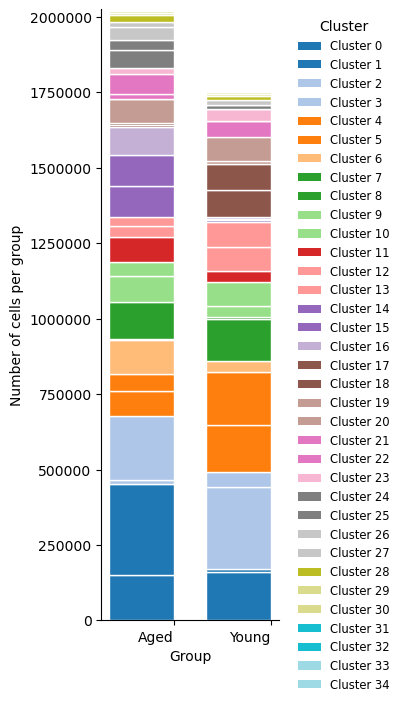

In [105]:
# Assuming 'adata' is your AnnData object and it's already loaded
# Custom order of groups for plotting
group_order = ['Aged', 'Young']
adata.obs['Group'] = pd.Categorical(adata.obs['Group'], categories=group_order, ordered=True)
cluster_group_counts = adata.obs.groupby(['leiden', 'Group']).size().unstack(fill_value=0)

# Define the bar width and the spacing between groups
bar_width = 0.4
group_spacing = 0.2  # Space between the groups

# Calculate the x position of the first bar in each group
bar_positions = np.arange(len(group_order)) * (bar_width + group_spacing)

# Create the plot with a larger figure size for better readability and space for legend
fig, ax = plt.subplots(figsize=(5, 7.5))  # Adjusted figure size for better display

# Using the 'tab20' colormap for better color distinction
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_group_counts.index)))

for i, cluster in enumerate(cluster_group_counts.index):
    # Plot each cluster's counts for each group, one on top of the other
    bottoms = cluster_group_counts.iloc[:i].sum() if i > 0 else np.zeros_like(bar_positions)
    ax.bar(bar_positions, cluster_group_counts.loc[cluster], color=colors[i], edgecolor='white', width=bar_width, label=f'Cluster {cluster}', bottom=bottoms)

# Formatting the plot
ax.ticklabel_format(style='plain', axis='y')

# Set the x-ticks to be in the center of the groups
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(group_order, rotation=0, ha='right')
ax.set_ylabel('Number of cells per group')
ax.set_xlabel('Group')

# Remove the top and right spines for cleaner aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Creating a legend and positioning it outside the plot on the right, with a smaller font size for compact fit
legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}') for i, cluster in enumerate(cluster_group_counts.index)]
ax.legend(handles=legend_elements, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize='small')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle in which to fit the plot and legend
plt.savefig('/home/mali3/Downloads/concat_1/number_of_cells_per_group_rotaiton_0.pdf', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

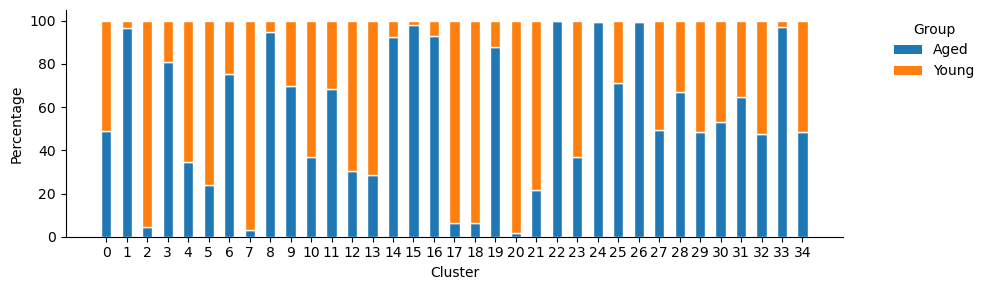

In [106]:
# First, ensure the 'Group' order
adata.obs['Group'] = pd.Categorical(adata.obs['Group'], categories=group_order, ordered=True)

# Recount with the 'Group' now ordered, if necessary
cluster_group_counts = adata.obs.groupby(['leiden', 'Group']).size().unstack(fill_value=0)

# Compute the sum of cells in each cluster to normalize group counts within each cluster
cluster_sums = cluster_group_counts.sum(axis=1)

# Compute relative percentages of each group within each cluster
relative_cluster_percentages = cluster_group_counts.div(cluster_sums, axis=0) * 100

plt.clf()

# Manually select color indices from the tab20 colormap
# Here, I'm selecting indices 4, 6, 10, and 15 as an example. Adjust these based on your color preference.
color_indices = [0, 2, 4, 6]
colors = plt.cm.tab20(np.linspace(0, 1, 20))[color_indices]

# Assuming 'relative_cluster_percentages' is already computed as per your previous snippet

plt.clf()

fig, ax = plt.subplots(figsize=(10, 3))
bar_width = 0.5

# Iterate over each cluster to create stacked bars using 'relative_cluster_percentages'
for cluster_index, cluster in enumerate(relative_cluster_percentages.index):
    bottom = 0  # Initialize the bottom to stack the bars
    for group_index, group in enumerate(group_order):
        # Correctly using 'relative_cluster_percentages' to get the height
        height = relative_cluster_percentages.loc[cluster, group] if group in relative_cluster_percentages.columns else 0
        # Plot the bar with the chosen color from 'colors'
        ax.bar(cluster_index, height, bottom=bottom, width=bar_width, edgecolor='white', color=colors[group_index], label=group if bottom == 0 else "")
        bottom += height  # Update the bottom position for the next group in the stack

# Set the x-ticks labels, titles, and other plot labels
ax.set_xticks(range(len(relative_cluster_percentages.index)))
ax.set_xticklabels(relative_cluster_percentages.index, rotation=0, ha='center')
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster')
ax.set_title('')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create legend for groups
legend_elements = [Patch(facecolor=colors[i], label=group_order[i]) for i in range(len(group_order))]
ax.legend(handles=legend_elements, title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('/home/mali3/Downloads/concat_1/_horizontal_bar_pot.png', dpi=300, bbox_inches='tight')
plt.show()

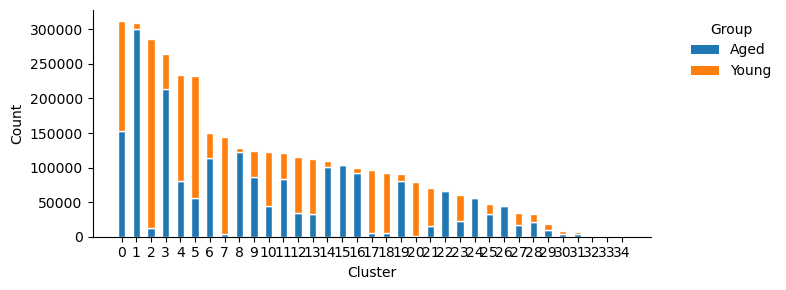

In [107]:
# Manually select color indices from the tab20 colormap
# Adjust these indices to select your preferred colors
color_indices = [0, 2, 4, 6]
colors = plt.cm.tab20(np.linspace(0, 1, 20))[color_indices]

fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
bar_width = 0.5

# Iterate over each cluster to create stacked bars using 'cluster_group_counts'
for cluster_index, cluster in enumerate(cluster_group_counts.index):
    bottom = 0  # Initialize the bottom to stack the bars
    for group_index, group in enumerate(group_order):
        # Use 'cluster_group_counts' to get the count for the current group and cluster
        count = cluster_group_counts.loc[cluster, group] if group in cluster_group_counts.columns else 0
        # Plot the bar with the selected color from 'colors'
        ax.bar(cluster_index, count, bottom=bottom, width=bar_width, edgecolor='white', color=colors[group_index], label=group if bottom == 0 else "")
        bottom += count  # Update the bottom position for the next group in the stack

# Set the x-ticks labels, titles, and other plot labels
ax.set_xticks(range(len(cluster_group_counts.index)))
ax.set_xticklabels(cluster_group_counts.index, rotation=0, ha='center')
ax.set_ylabel('Count')  # Change label to 'Count'
ax.set_xlabel('Cluster')
ax.set_title('')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create legend for groups
legend_elements = [Patch(facecolor=colors[i], label=group_order[i]) for i in range(len(group_order))]
ax.legend(handles=legend_elements, title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


plt.tight_layout()
plt.savefig('/home/mali3/Downloads/concat_1/_stacked_bar_young_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#The end 